# Tutorial de pronósticos de sismicidad en grillas - El caso del experimento de Italia de 2010

En este tutorial, descargaremos y evaluaremos pronósticos de sismicidad para Italia, los cuales proporcionan tasas de terremotos de cinco años invariantes en el tiempo en un conjunto de celdas (o grilla) previamente diseñada por el Equipo para el Estudio sobre la Predictabilidad de Terremotos (CSEP, por sus siglas en inglés). Estos pronósticos participaron en el experimento CSEP para Italia de 2010, el cual tuvo como objetivo evaluar la capacidad predictiva de modelos de sismicidad contra terremotos observados (ver [Werner et al, 2010](https://doi.org/10.4401/ag-4840), [Taroni et al, 2018](https://doi.org/10.1785/0220180031) para más detalles).

El proceso requiere esencialmente de tres pasos:
1. Leer los archivos que contienen los pronósticos y graficarlos en un mapa.
2. Definir un catálogo de terremotos con el cual se realizará la evaluación.
3. Llevar a cabo las evaluaciones utilizando pyCSEP e interpretar los resultados.
    
Para este ejercicio, nos limitaremos a proporcionar una breve introducción sobre cómo utilizar pyCSEP; no obstante, invitamos a nuestrxs lectorxs a explorar todas las utilidades de pyCSEP. La documentación se puede encontrar [aquí](https://docs.cseptesting.org/), y cualquier problema puede ser reportado en [la página Github de PyCSEP](https://github.com/SCECcode/pycsep).

In [1]:
# La paquetería principal de pyCSEP se encuentra en el nivel superior y hay que importarla
import csep
# Asimismo, es necesario importar las clases y rutinas de evaluación del módulo csep.core
from csep.core import regions, poisson_evaluations
# En el módulo csep.utils se encuentras otras utilidades importantes para este ejercicio
from csep.utils import datasets, time_utils, comcat, plots, readers

import numpy
import cartopy

## 1. Leer los archivos que contienen los pronósticos

Empezaremos por configurar los parámetros de nuestro experimento. Las fechas iniciales y finales del mismo deben ser elegidas de acuerdo con la creación de los pronósticos de sismicidad. Por ejemplo, si el pronóstico fue calibrado con terremotos observados entre 2013 y 2018, el catálogo con el que se contrastará dicho pronóstico deberá contener terremotos observados a partir del 1ero de enero de 2019 para que la evaluación sea completamente prospectiva. Asimismo, si pronóstico fue diseñado para describir actividad sísmica durante un periodo de cinco años, el catálogo de evaluación también deberá tener una duración de cinco años. De lo contrario, el pronóstico deberá ser reescalado a la duración del catálogo.

In [2]:
## Configuremos los parámetros del experimento
start_date = time_utils.strptime_to_utc_datetime('2010-01-01 00:00:00.0')
end_date = time_utils.strptime_to_utc_datetime('2015-01-01 00:00:00.0')

Descargaremos del fólder `workshop_data/forecasts` dos pronósticos de sismicidad en grillas, también llamados grid-based forecasts, en formato `.dat`, el cual es un formato estándar para CSEP. Más información sobre los múltiples formatos que lxs usuarixs pyCSEP pueden utilizar se encuentra [en la documentación] (https://docs.cseptesting.org/concepts/forecasts.html). Un ejemplo del formato `.dat` se muestra a continuación:
```
# min_lat | max_lat | min_lon | max_lon | min_prof | max_prof | min_mag | max_mag | tasa | masc
5.50	5.60	44.90	45.00	0.00	30.00	4.95	5.05	3.3000000000000003e-05	1
5.50	5.60	44.90	45.00	0.00	30.00	5.05	5.15	2.5999999999999998e-05	1
5.50	5.60	44.90	45.00	0.00	30.00	5.15	5.25	2.0000000000000002e-05	1
...
5.50	5.60	45.00	45.10	0.00	30.00	4.95	5.05	3.3000000000000003e-05	1
5.50	5.60	45.00	45.10	0.00	30.00	5.05	5.15	2.5999999999999998e-05	1
...
```

Modelo 1 - Sismicidad suavizada de alta resolución - [Werner et al., 2010](https://doi.org/10.4401/ag-4839)

In [3]:
## Descargar desde pyCSEP
werner_forecast = csep.load_gridded_forecast('HRSS_m1.dat',
                                             name='Werner, et al (2010)')

Modelo 2 - Modelo de sismicidad que informa el modelo de peligro sísmico de Italia de 2004 - [Meletti et al., 2004](http://zonesismiche.mi.ingv.it/)

In [4]:
## Lxs usuarixs tendrían que editar la ubicación de este archivo dependiendo de la configuración de pyCSEP
meletti_forecast = csep.load_gridded_forecast("MPS04after.dat",
                                              name ="Meletti et al (2010), MPS working group")

Los pronósticos en grillas heredan automáticamente la región de evaluación a partir la columna 'masc' del archivo de entrada (ver arriba), por lo  que no es necesario definir dicha región explícitamente. No obstante, es importante verificar que las regiones de los pronósticos y el catálogo sea exactamente la misma para que la comparación entre modelos de lleve a cabo de manera adecuada.

In [6]:
## Verificación - Si ambos pronósticos comparten la misma región, esta prueba no arrojará ningún mensaje.
numpy.testing.assert_allclose(meletti_forecast.region.midpoints(), werner_forecast.region.midpoints())

Para visualizar nuestros pronósticos sobre un mapa, usaremos la función `forecast.plot()` e incluiremos algunas especificaciones, las cuales incluyen:

    - Asignar un título
    - Poner etiquetas a los ejes geográficos
    - Dibujar fronteras entre países
    - Asignar un ancho de línea de 0.5 a dichas fronteras
    - Seleccionar la capa ESRI Imagery como base del mapa
    - Asignar la opción 'rainbow' como colormap. Esta y otras opciones se obtienen de la librería matplotlib.cm
    - Definir un valor de transparencia alpha de 0.8 (por default alpha es igual a 1, o no transparente)
    - Pasar el objeto cartopy.crs.Projection() como Projection al mapa 
    
La descripción completa de todos los argumentos para graficar en matplotlib se encuentran en `csep.utils.plots.plot_spatial_dataset`

In [5]:
args_dict = {'title': 'Italy 10 year forecast',
             'grid_labels': True,
             'borders': True,
             'feature_lw': 0.5,
             'basemap': 'ESRI_imagery',
             'cmap': 'rainbow',
             'alpha_exp': 0.8,
             'projection': cartopy.crs.Mercator()}

Aunque típicamente el tamaño del mapa no se define explícitamente, esto se puede hacer a través del argumento extent

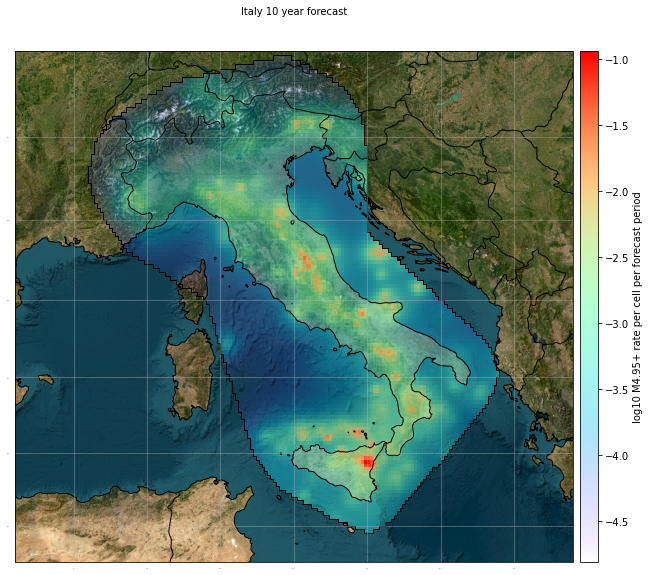

In [6]:
ax = werner_forecast.plot(extent=[3, 22, 35, 48],
                          show=True,
                          plot_args=args_dict)

In [ ]:
## Este es un ejercicio para lxs usuarixs. Grafiquen en un mapa el pronóstico de sismicidad de Meletti.
ax = ???

## 2. Importar el catálogo de evaluación

El siguiente paso es importar el catálogo de sismicidad observada que queremos utilizar para evaluar nuestros pronósticos de sismicidad. Existen varias maneras de importar catálogos de evaluación en pyCSEP, incluyendo el acceso directo de catálogos a través de agencias sismológicas como ComCat para terremotos en Estados de Unidos, GeoNet para Nueva Zelanda, BSI para Italia, etc. De igual manera, existen varias rutinas de lectura de otros catálogos en el paquete pyCSEP, incluyendo los catálogos JMA (Japón) e INGV HORUS (Italia), las cuales están descritos en la documentación. Estas funciones se encuentran en el archivo csep/utils/readers.py. En este tutorial, utilizaremos el Bolletino Sismico Italiano de INGV. 

In [7]:
## Solicitemos el catálogo de la agencia sismológica (requeriremos acceso a internet)
italy_test_catalog = csep.query_bsi(start_time = start_date, end_time=end_date)

Fetched BSI catalog in 8.224234819412231 seconds.

Downloaded catalog from Bollettino Sismico Italiano (BSI) with following parameters
Start Date: 2010-01-01 17:12:49.970000+00:00
End Date: 2014-12-31 15:47:33.650000+00:00
Min Latitude: 32.7808 and Max Latitude: 48.8
Min Longitude: 3.13 and Max Longitude: 21.0
Min Magnitude: 2.5
Found 4972 events in the BSI catalog.


Imprimamos el catálogo para verificar su duración, así como las ubicaciones y magnitudes de los eventos que contiene:

In [ ]:
# Un ejercicio para lxs usuarixs
print(dir(italy_test_catalog))  # Imprima todas las funciones que pueden ser realizadas sobre un catálogo

Podemos también filtrar el catálogo a un rango de tiempo, espacio y magnitud determinado. Es crucial hacer un filtrado del catálogo para que este esté definido en la misma región del pronóstico y poder así realizar la evaluación. Esta es la razón por la cual verificamos en un paso anterior que tanto el pronóstico como el catálogo compartan exactamente la misma región geográfica.

In [8]:
italy_test_catalog = italy_test_catalog.filter_spatial(werner_forecast.region)

Note que nuestro rango de magnitud es inconsistente con los parámetros que definimos anteriormente, por lo que tenemos que filtrar en este dominio también. Esto es realmente importante para poder evaluar de manera justa los pronósticos. Si no lo cree, intente correr otra vez este tutorial sin aplicar este filtro.

In [9]:
italy_test_catalog = italy_test_catalog.filter('magnitude >= 4.95')

Si el filtro anterior ha sido implementado, el catálogo se ha reducido a 13 eventos. 
Imprima el catálogo utilizando el comando estándar `print` para verificar su duración, las magnitudes y los epicentros de los eventos, así como el número total de terremotos observados.

## 3. Implementar las evaluaciones estadísticas

Ahora deseamos responder algunas preguntas sobre nuestros pronósticos y sus capacidades predictivas. En este ejemplo, investigaremos las propiedades espaciales de los modelos y qué tan competentes son para describir la distribución espacial de sismicidad observada.

Las pruebas de consistencia para pronósticos basados en grillas disponibles en pyCSEP son las pruebas N (número), S (espacial) y M (magnitud), cuya descripción puede ser consultada tanto en [Schorlemmer et al, 2007](https://doi.org/10.1785/gssrl.78.1.17) como [Zechar et al, 2010](https://doi.org/10.1785/0120090192). Estas pruebas han encuentran en el archivo `poisson_evaluations`, el cual se exporta para este ejercicio como `poisson`.

Para llevar a cabo una prueba de consistencia, debemos especificar qué pronóstico deseamos evaluar así como el catálogo de evaluación. La prueba espacial requiere realizar simulaciones basadas en el pronóstico de sismicidad para determinar sus intervalos de confianza (o incertidumbres).

In [10]:
spatial_test_result_werner = poisson_evaluations.spatial_test(werner_forecast, italy_test_catalog)

In [11]:
## Lleve a cabo la prueba espacial para el segundo pronóstico
spatial_test_result_meletti = poisson_evaluations.spatial_test(meletti_forecast, italy_test_catalog)

A través de la función csep.write.json(), pyCSEP puede almacenar objetos en formato JSON. De esta manera, se pueden almacenar los resultados de nuestras pruebas y consultarlos tiempo después utilizando la función `csep.load_evaluation_result()`.

In [ ]:
## Ejercicio opcional. Ejecute esta línea de código para almacenar los resultados de la prueba espacial 
## para el modelo de Meletti.
csep.write_json(spatial_test_result_meletti, 'example_spatial_test.json')

Podemos graficar los resultados de la evaluación utilizando la función `plot_poisson_consistency_test` del archivo `plots` y la carpeta `csep.utils`. Más detalles sobre esta función se encuentran [en la documentación](https://docs.cseptesting.org/reference/generated/csep.utils.plots.plot_poisson_consistency_test.html#csep.utils.plots.plot_poisson_consistency_test). Aquí, una vez más, empleamos un diccionario para definir los parámetros de nuestra figura.

In [12]:
args = {'figsize': (6,5),
        'title': r'$\mathcal{S}-\mathrm{test}$',
        'title_fontsize': 18,
        'xlabel': 'Log-likelihood',
        'xticks_fontsize': 12,
        'ylabel_fontsize': 12,
        'linewidth': 1,
        'capsize': 4,
        'hbars':True,
        'tight_layout': True}

Graficaremos ahora los resultados de ambos pronósticos para compararlos. Definiremos el parámetro `one_sided_lower=True`, de modo que el pronóstico sea inconsistente con las observaciones si la estadística observada (círculo) se encuentra dentro del rango de incertidumbre del modelo (barra).

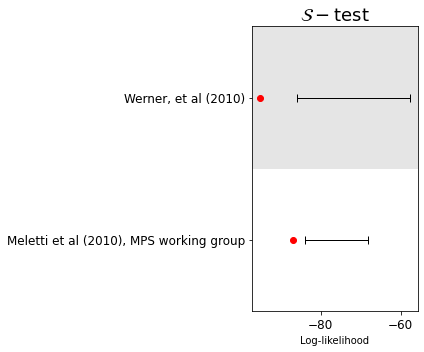

In [13]:
ax = plots.plot_poisson_consistency_test([spatial_test_result_werner, spatial_test_result_meletti],
                                         one_sided_lower=True, plot_args=args)

Si lxs usuarixs están interesadxs en analizar otras componentes de los pronósticos, pueden repetir el proceso para las pruebas número y de magnitud utilizando las funciones `number_test` o `magnitude_test` del archivo `poisson_evaluations`. Adicionalmente, se les invita a realizar las pruebas `likelihood_test` y `conditional_likelihood_test` (también del archivo `poisson_evaluations`).

¿Cómo deberían interpretarse estos resultados? ¿Hay otras pruebas que podrían ser útiles? ¿Cuáles son sus conclusiones sobre el desempeño de estos pronósticos?

En caso de tener más dudas sobre las capacidades computacionales de pyCSEP, lxs usuarixs pueden:
* Consultar la [teoría](https://docs.cseptesting.org/getting_started/theory.html) y la [implementación](https://docs.cseptesting.org/concepts/evaluations.html) de estos y otros métodos estadísticos para evaluar pronósticos de sismicidad.
* Cambiar el periodo de la evaluación
* Filtrar el catálogo a un periodo de evaluación o un rango de magnitud diferente
* Utilizar pyCSEP para evaluar otros pronósticos de sismicidad en grilla

### Referencias bibliográficas 

-Schorlemmer, D., M. Gerstenberger, S. Wiemer, D. D. Jackson, and D. A. Rhoades (2007). Earthquake likelihood model testing, Seismological Research Letters 78 17-29.  
-Taroni, M., W. Marzocchi, D. Schorlemmer, M. J. Werner, S. Wiemer, J. D. Zechar, L. Heiniger, F. Euchner (2018). Prospective CSEP Evaluation of 1‐Day, 3‐Month, and 5‐Yr Earthquake Forecasts for Italy, Seismological Research Letters (2018) 89 (4): 1251–1261  
-Werner, M. J., J. D. Zechar, W. Marzocchi, S., CSEP-Italy Working Group (2010). Retrospective evaluation of the five-year and ten-year CSEP-Italy earthquake forecasts, Annals of Geophysics, 53, 3.  
-Zechar, J. D., M. C. Gerstenberger, and D. A. Rhoades (2010). Likelihood-Based Tests for Evaluating Space-Rate-Magnitude Earthquake Forecasts, Bulletin of the Seismological Society of America 100 1184-1195.